<a href="https://colab.research.google.com/github/Amzilynn/Geoepidemiology-Profiling/blob/main/Geoepidemiology_dataexploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load your datasets
modis_df = pd.read_csv('master_modis_all_regions.csv')
gpm_df = pd.read_csv('master_gpm_all_regions.csv')
climate_df = pd.read_csv('master_climate_2022_2024.csv')

#  Check the columns to decide the merge key
print(modis_df.columns)
print(gpm_df.columns)
print(climate_df.columns)

Index(['LST_Day_1km_max', 'LST_Day_1km_mean', 'LST_Day_1km_min',
       'LST_Night_1km_max', 'LST_Night_1km_mean', 'LST_Night_1km_min',
       'QC_Day_max', 'QC_Day_mean', 'QC_Day_min', 'QC_Night_max',
       'QC_Night_mean', 'QC_Night_min', 'date', 'region', 'satellite', 'year',
       'month', 'date_dt', 'temp_diff'],
      dtype='object')
Index(['date', 'precipitation_max', 'precipitation_mean', 'precipitation_min',
       'precipitation_sum', 'region', 'year', 'date_dt'],
      dtype='object')
Index(['region', 'year', 'date', 'date_dt', 'temperature_2m',
       'relative_humidity', 'dewpoint_2m', 'total_precipitation',
       'wind_speed_10m', 'soil_water_layer_1', 'soil_water_layer_2',
       'soil_water_layer_3'],
      dtype='object')


In [2]:
import pandas as pd

# 1. Load datasets
modis_df = pd.read_csv('master_modis_all_regions.csv')
gpm_df = pd.read_csv('master_gpm_all_regions.csv')
climate_df = pd.read_csv('master_climate_2022_2024.csv')

# 2. Ensure 'date' columns are datetime
modis_df['date'] = pd.to_datetime(modis_df['date'])
gpm_df['date'] = pd.to_datetime(gpm_df['date'])
climate_df['date'] = pd.to_datetime(climate_df['date'])

# 3. Merge MODIS + GPM daily
daily_merge = pd.merge(
    modis_df,
    gpm_df,
    on=['region', 'year', 'date'],
    how='outer',  # keep all days even if missing in one dataset
    suffixes=('_modis', '_gpm')
)

# 4. Merge with Climate data
daily_merge = pd.merge(
    daily_merge,
    climate_df,
    on=['region', 'year', 'date'],
    how='outer',
    suffixes=('', '_climate')
)

# 5. Save final daily dataset
daily_merge.to_csv('master_3_Test.csv', index=False)

print("Daily datasets merged successfully.")


Daily datasets merged successfully.


In [3]:
# Show the first 5 rows
print(daily_merge.head())

# Optional: show the first 10 rows
print(daily_merge.head(10))


   LST_Day_1km_max  LST_Day_1km_mean  LST_Day_1km_min  LST_Night_1km_max  \
0          15742.0      15135.674716          14859.0            15013.0   
1              NaN               NaN              NaN                NaN   
2              NaN               NaN              NaN                NaN   
3              NaN               NaN              NaN                NaN   
4              NaN               NaN              NaN                NaN   

   LST_Night_1km_mean  LST_Night_1km_min  QC_Day_max  QC_Day_mean  QC_Day_min  \
0        14814.252183            14443.0        81.0     2.930647         0.0   
1                 NaN                NaN         NaN          NaN         NaN   
2                 NaN                NaN         NaN          NaN         NaN   
3                 NaN                NaN         NaN          NaN         NaN   
4                 NaN                NaN         NaN          NaN         NaN   

   QC_Night_max  ...  date_dt_gpm     date_dt temperatur

In [4]:
daily_merge.isnull().sum()

,0
LST_Day_1km_max,4795
LST_Day_1km_mean,4795
LST_Day_1km_min,4795
LST_Night_1km_max,4809
LST_Night_1km_mean,4809
LST_Night_1km_min,4809
QC_Day_max,4795
QC_Day_mean,4795
QC_Day_min,4795
QC_Night_max,4795


In [7]:
daily_merge.shape

(5480, 33)

In [8]:
# Number of rows where MODIS is missing
missing_modis = daily_merge['LST_Day_1km_max'].isna().sum()
print("Missing MODIS rows:", missing_modis)

# Number of rows where GPM is missing
missing_gpm = daily_merge['precipitation_max'].isna().sum()
print("Missing GPM rows:", missing_gpm)

# Number of rows where Climate is missing
missing_climate = daily_merge['temperature_2m'].isna().sum()
print("Missing Climate rows:", missing_climate)


Missing MODIS rows: 4795
Missing GPM rows: 0
Missing Climate rows: 15


In [13]:
import pandas as pd
import numpy as np

# 1️⃣ Load your merged dataset
daily_merge = pd.read_csv('master_3_Test.csv')

# 2️⃣ Ensure 'date' column is datetime
daily_merge['date'] = pd.to_datetime(daily_merge['date'])

# 3️⃣ Sort by region and date
daily_merge = daily_merge.sort_values(['region', 'date'])

# 4️⃣ Columns to interpolate (MODIS LST)
modis_cols = [
    'LST_Day_1km_max', 'LST_Day_1km_mean', 'LST_Day_1km_min',
    'LST_Night_1km_max', 'LST_Night_1km_mean', 'LST_Night_1km_min'
]

# 5️⃣ Interpolate missing MODIS values per region using `transform`
daily_merge[modis_cols] = daily_merge.groupby('region')[modis_cols] \
    .transform(lambda group: group.interpolate(method='linear'))  # linear interpolation

# 6️⃣ Optional: fill any remaining NaNs at start/end using `transform`
daily_merge[modis_cols] = daily_merge.groupby('region')[modis_cols] \
    .transform(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# 7️⃣ Save the interpolated daily dataset
daily_merge.to_csv('master_3_Test.csv', index=False)

# 8️⃣ Quick check
print(daily_merge.head(10))
print(daily_merge[modis_cols].isna().sum())  # should be 0

/tmp/ipython-input-3962539528.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda group: group.fillna(method='bfill').fillna(method='ffill'))
/tmp/ipython-input-3962539528.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda group: group.fillna(method='bfill').fillna(method='ffill'))


   LST_Day_1km_max  LST_Day_1km_mean  LST_Day_1km_min  LST_Night_1km_max  \
0         15742.00      15135.674716        14859.000          15013.000   
1         15734.25      15134.682066        14770.125          15015.625   
2         15726.50      15133.689416        14681.250          15018.250   
3         15718.75      15132.696766        14592.375          15020.875   
4         15711.00      15131.704116        14503.500          15023.500   
5         15703.25      15130.711466        14414.625          15026.125   
6         15695.50      15129.718815        14325.750          15028.750   
7         15687.75      15128.726165        14236.875          15031.375   
8         15680.00      15127.733515        14148.000          15034.000   
9         15647.25      15111.455632        14136.125          15025.750   

   LST_Night_1km_mean  LST_Night_1km_min  QC_Day_max  QC_Day_mean  QC_Day_min  \
0        14814.252183          14443.000        81.0     2.930647         0.0   
1

In [14]:
import pandas as pd

# Load your daily interpolated dataset
df = pd.read_csv('master_3_Test.csv')

# Ensure date is datetime type
df['date_dt'] = pd.to_datetime(df['date'])

# Quick overview
print(df.info())
print(df.describe().round(2))
print(df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LST_Day_1km_max      5480 non-null   float64       
 1   LST_Day_1km_mean     5480 non-null   float64       
 2   LST_Day_1km_min      5480 non-null   float64       
 3   LST_Night_1km_max    5480 non-null   float64       
 4   LST_Night_1km_mean   5480 non-null   float64       
 5   LST_Night_1km_min    5480 non-null   float64       
 6   QC_Day_max           685 non-null    float64       
 7   QC_Day_mean          685 non-null    float64       
 8   QC_Day_min           685 non-null    float64       
 9   QC_Night_max         685 non-null    float64       
 10  QC_Night_mean        685 non-null    float64       
 11  QC_Night_min         685 non-null    float64       
 12  date                 5480 non-null   object        
 13  region               5480 non-nul

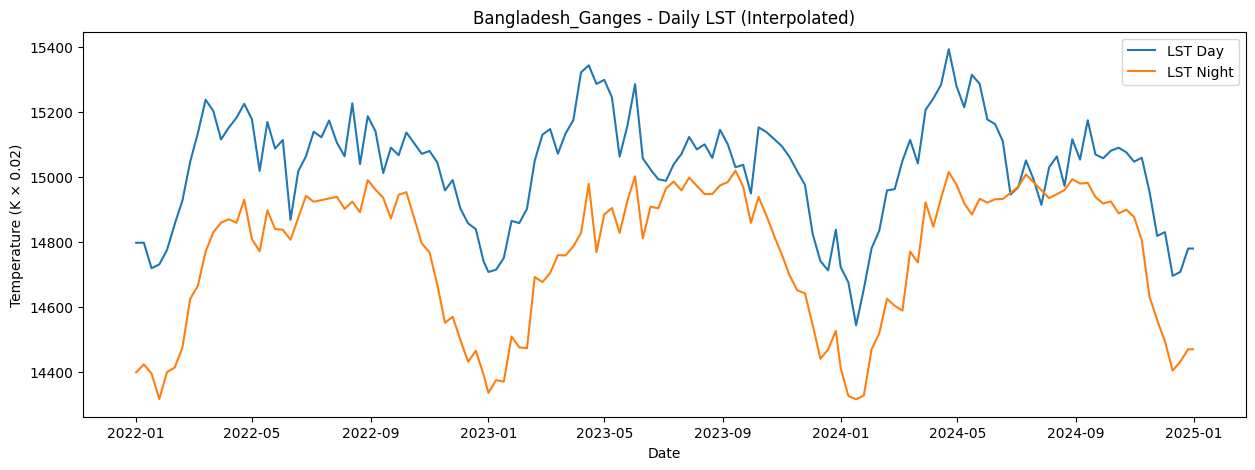

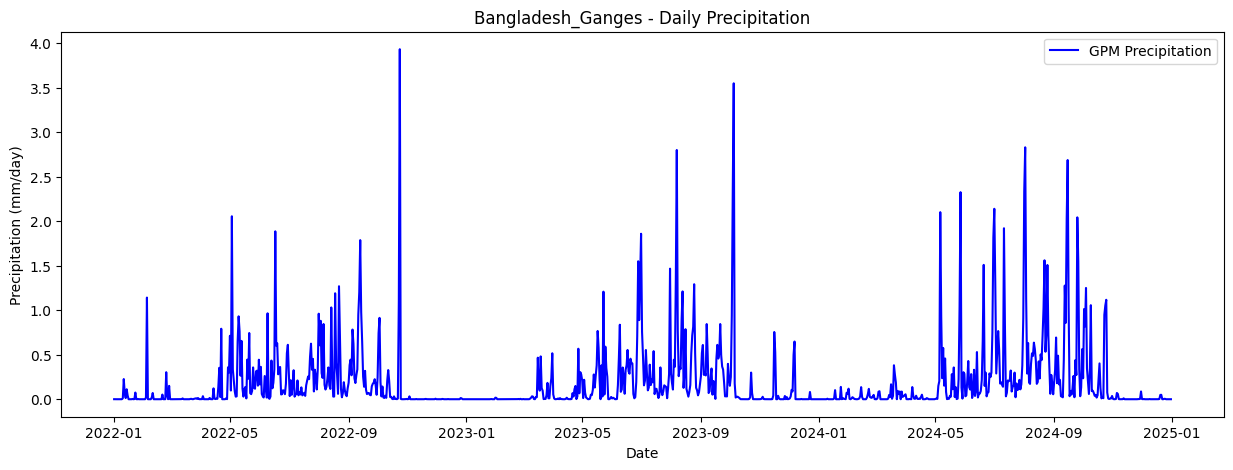

In [15]:
import matplotlib.pyplot as plt

# Choose a region
region = 'Bangladesh_Ganges'
df_region = df[df['region'] == region]

# Example: Daily LST Day/Night
plt.figure(figsize=(15,5))
plt.plot(df_region['date_dt'], df_region['LST_Day_1km_mean'], label='LST Day')
plt.plot(df_region['date_dt'], df_region['LST_Night_1km_mean'], label='LST Night')
plt.title(f'{region} - Daily LST (Interpolated)')
plt.xlabel('Date')
plt.ylabel('Temperature (K × 0.02)')  # MODIS LST unit
plt.legend()
plt.show()

# Example: Daily precipitation
plt.figure(figsize=(15,5))
plt.plot(df_region['date_dt'], df_region['precipitation_mean'], color='blue', label='GPM Precipitation')
plt.title(f'{region} - Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()


<Figure size 1500x500 with 0 Axes>

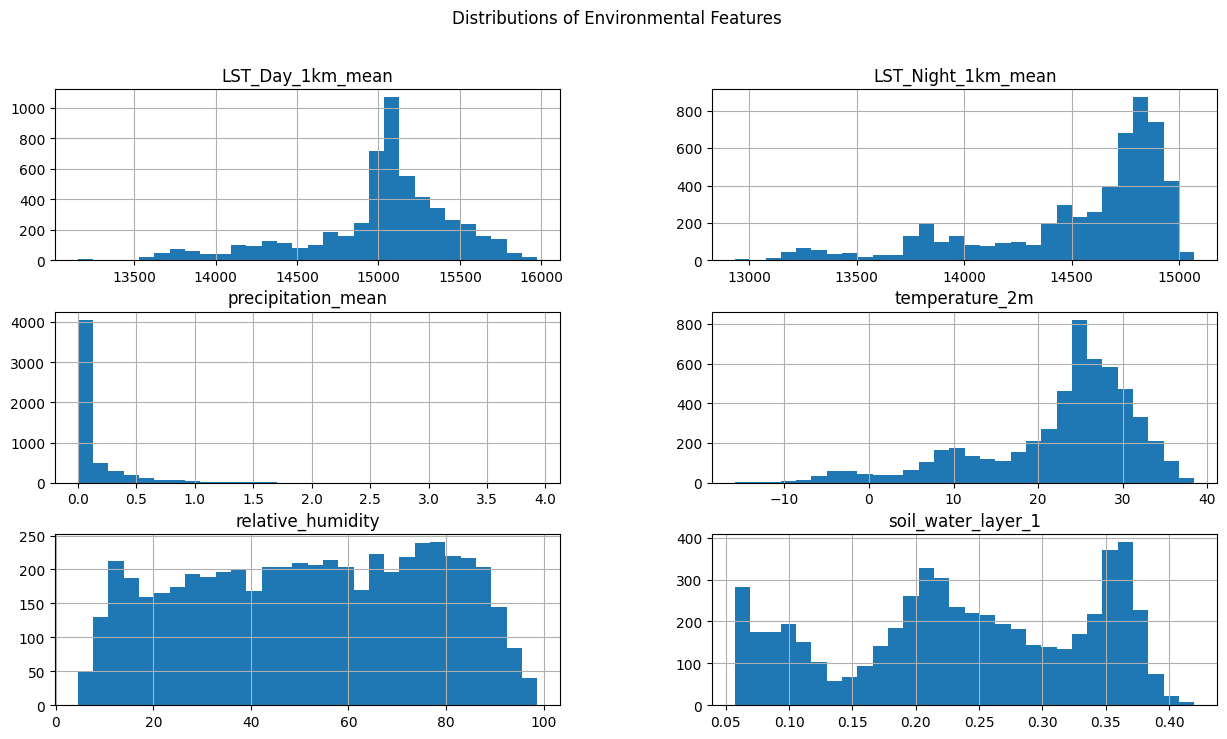

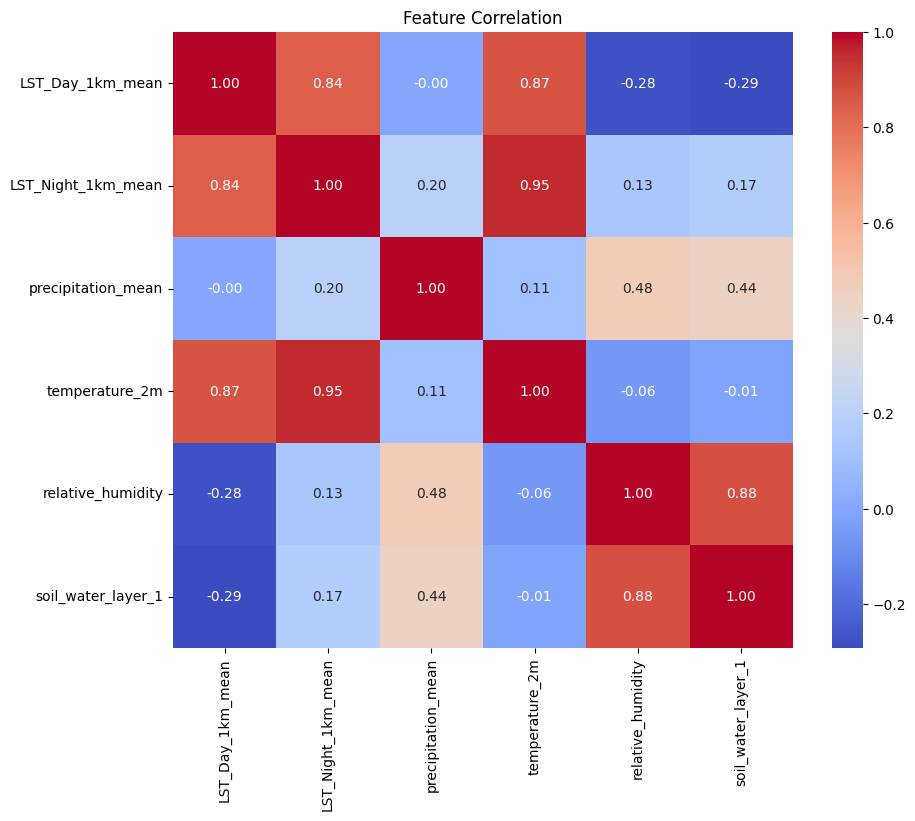

In [16]:
import seaborn as sns

# Histogram of environmental features
env_features = [
    'LST_Day_1km_mean', 'LST_Night_1km_mean', 'precipitation_mean',
    'temperature_2m', 'relative_humidity', 'soil_water_layer_1'
]

plt.figure(figsize=(15,5))
df[env_features].hist(bins=30, figsize=(15,8))
plt.suptitle('Distributions of Environmental Features')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[env_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation')
plt.show()


In [17]:
# Count missing per region
missing_per_region = df.groupby('region')[env_features].apply(lambda x: x.isna().sum())
print(missing_per_region)


                    LST_Day_1km_mean  LST_Night_1km_mean  precipitation_mean  \
region                                                                         
Amazon_Peru                        0                   0                   0   
Bangladesh_Ganges                  0                   0                   0   
Beijing_China                      0                   0                   0   
California_Central                 0                   0                   0   
Sahel_Mali                         0                   0                   0   

                    temperature_2m  relative_humidity  soil_water_layer_1  
region                                                                     
Amazon_Peru                      3                  3                   3  
Bangladesh_Ganges                3                  3                   3  
Beijing_China                    3                  3                   3  
California_Central               3                  3      

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# 1. Drop QC columns
qc_cols = [col for col in df.columns if 'QC' in col]
df_clean = df.drop(columns=qc_cols)

# 2. Keep numeric columns only (LST, precipitation, soil, climate)
num_cols = df_clean.select_dtypes(include=['float', 'int']).columns
df_num = df_clean[num_cols].copy()

# 3. Fill remaining NaNs
df_num = df_num.ffill().bfill()

# 4. Standardize features (important for KMeans)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

print("Data ready for K-Means:", df_scaled.shape)


Data ready for K-Means: (5480, 21)


In [36]:
# Number of clusters (profiles) - start with 5
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(df_scaled)

print(df_clean[['cluster']].value_counts())


cluster
2          1397
1          1346
0          1307
3          1091
4           339
Name: count, dtype: int64


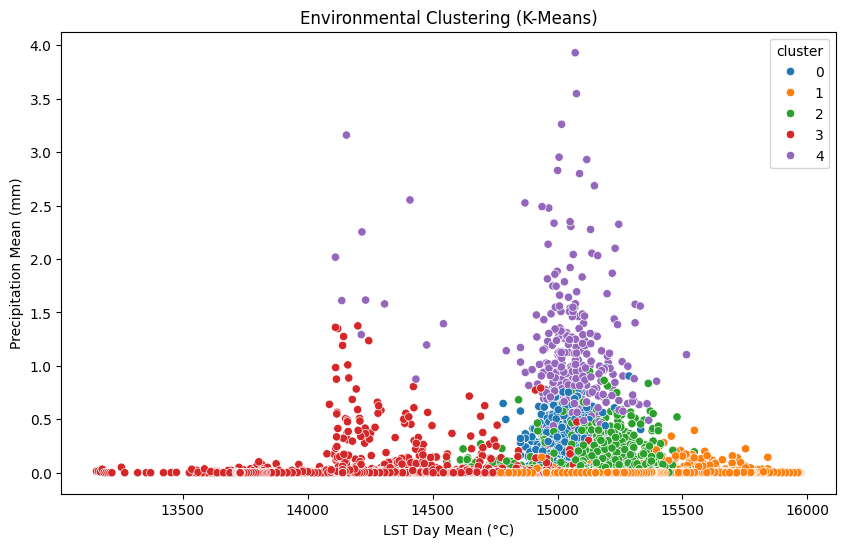

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: LST_Day vs Precipitation colored by cluster
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=df_clean['LST_Day_1km_mean'],
    y=df_clean['precipitation_mean'],
    hue=df_clean['cluster'],
    palette='tab10'
)
plt.xlabel('LST Day Mean (°C)')
plt.ylabel('Precipitation Mean (mm)')
plt.title('Environmental Clustering (K-Means)')
plt.show()


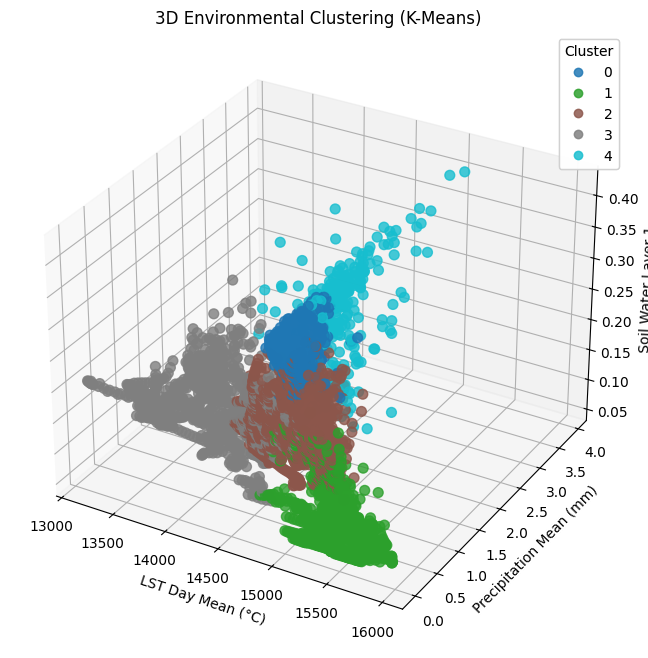

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Pick three features for the 3D plot
x = df_clean['LST_Day_1km_mean']
y = df_clean['precipitation_mean']
z = df_clean['soil_water_layer_1']
clusters = df_clean['cluster']

# Create 3D figure
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=clusters, cmap='tab10', s=50, alpha=0.8)

# Axes labels
ax.set_xlabel('LST Day Mean (°C)')
ax.set_ylabel('Precipitation Mean (mm)')
ax.set_zlabel('Soil Water Layer 1')

# Title
ax.set_title('3D Environmental Clustering (K-Means)')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()
